IMPORT ALL

In [1]:
#   ---------  Project Forecast evaluation  ---------
#                 CNN PREDICTION MODEL 
#             
#                 ---------------------
#                   SEBASTIAN SUWADA 
#                 ---------------------
#


import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

2024-01-03 16:26:45.430269: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


PREPARE DATA

In [2]:
def prepareData(filename):
    df = pd.read_csv(filename, sep=';')
    data_orginal = df[df['Category'] == 'Furniture'].copy()
    data_orginal = data_orginal[['Order Date','Sales']].set_index('Order Date')
    data_orginal = data_orginal.groupby('Order Date').sum().reset_index()
    data_orginal['Order Date'] = pd.to_datetime(data_orginal['Order Date'])
    resampled = data_orginal.resample('MS', on='Order Date').mean()
    return resampled


## IMPORT DATA
filename = '/Users/sebastiansuwada/Desktop/Predictive Analytics/Project/Code/data.csv'
orginalData = prepareData(filename)

TRANSFORM AND SCALE DATA - using sklearn and standard scaler 

In [4]:

def cnnModelPrepareData(df_):
    ## Scalar initial data
    # scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = StandardScaler()
    df_cnn = scaler.fit_transform(df_)

    timestep = 12

    X = []
    Y = []

    for i in range(len(df_cnn) - (timestep)):
        X.append(df_cnn[i:i+timestep])
        Y.append(df_cnn[i+timestep])

    X = np.array(X)
    Y = np.array(Y)
    
    k = int((len(X)-3)*0.75)

    X_train = X[:k]
    Y_train = Y[:k]
    X_test = X[k:]
    Y_test = Y[k:]

    return X_train, Y_train, X_test, Y_test, scaler

## Transform and Scale data using sklearn library and Standard Scaler
X_train, Y_train, X_test, Y_test, scaler = cnnModelPrepareData(orginalData)

PERFORM CNN MODEL FORECAST - CNNModel functions estimates forecast for CNN, CNNEstimation takes 'num_forecasts' and make average of num_forecasts * 

In [11]:
def evaluateForecast(initial, forecast):
    initial_values = np.array(initial)
    forecast_values = np.array(forecast)

    # Mean Squared Error (MSE) and Mean Absolute Percentage Error (MAPE)
    mse = np.mean((initial_values - forecast_values)**2)
    mape = np.mean(np.abs((initial_values - forecast_values) / initial_values)) * 100
    rmse = np.sqrt(mse)
    return mse, mape, rmse

def CNNModel(X_train, Y_train, X_test, Y_test, scaler):
    # 1D CNN model
    # "In this study, a 1D CNN model is proposed which consists of 3 one-dimension"
    modelCNN = Sequential() 
    modelCNN.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(12, 1)))
    modelCNN.add(MaxPooling1D(pool_size=2))
    modelCNN.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
    modelCNN.add(MaxPooling1D(pool_size=2))
    modelCNN.add(Conv1D(filters=128, kernel_size=2, activation='relu'))

    # modelCNN.add(MaxPooling1D(pool_size=2))
    modelCNN.add(Flatten())
    modelCNN.add(Dense(100, activation='relu'))
    modelCNN.add(Dense(1))  # Number of neurons
    modelCNN.compile(optimizer='adam', loss='mse')
    modelCNN.fit(X_train, Y_train, epochs=200, verbose=0)
    # modelCNN.summary()
    
    preds = modelCNN.predict(X_test)
    preds = scaler.inverse_transform(preds)

    Ytest = np.array(Y_test)  
    Ytest = Ytest.reshape(-1,1) 
    Ytest = scaler.inverse_transform(Ytest)

    mse, mape, rmse = evaluateForecast(Ytest, preds)

    return preds, mape, mse, rmse 

def CNNestimation(num_forecasts, X_train, Y_train, X_test, Y_test, scaler):
    # Loop to generate forecasts
    all_forecasts = []
    all_mape = []
    all_mse = []
    all_rmse = []

    for i in range(num_forecasts):
        preds, mape, mse, rmse  = CNNModel(X_train, Y_train, X_test, Y_test, scaler)
        all_forecasts.append(preds)
        all_mape.append(mape)
        all_mse.append(mse)
        all_rmse.append(rmse)

        print('Iteration '+str(i)+' out of '+str(num_forecasts))
    
    average_forecast = np.mean(all_forecasts, axis=0)
    average_mape = np.mean(all_mape, axis=0)
    average_mse = np.mean(all_mse, axis=0)
    average_rmse = np.mean(all_rmse, axis=0)

    print(average_forecast, average_mape, average_mse, average_rmse)

    return average_forecast, average_mape, average_mse, average_rmse


num = 10
average_forecastCNN, average_mape, average_mse, average_rmse = CNNestimation(num, X_train, Y_train, X_test, Y_test, scaler)

file_path = '/Users/sebastiansuwada/Desktop/Predictive Analytics/Project/Code/CNNCSV.csv'

# Save the DataFrame to a CSV file
np.savetxt(file_path, average_forecastCNN, delimiter=',', fmt='%d')


1/1 [==============================] - 0s 128ms/step
Iteration 0 out of 10
1/1 [==============================] - 0s 126ms/step
Iteration 1 out of 10
1/1 [==============================] - 0s 132ms/step
Iteration 2 out of 10
1/1 [==============================] - 0s 119ms/step
Iteration 3 out of 10
1/1 [==============================] - 0s 119ms/step
Iteration 4 out of 10
1/1 [==============================] - 0s 116ms/step
Iteration 5 out of 10
1/1 [==============================] - 0s 117ms/step
Iteration 6 out of 10
1/1 [==============================] - 0s 120ms/step
Iteration 7 out of 10
1/1 [==============================] - 0s 123ms/step
Iteration 8 out of 10
1/1 [==============================] - 0s 117ms/step
Iteration 9 out of 10
[[ 891.5586 ]
 [ 601.69574]
 [ 567.5966 ]
 [ 520.4494 ]
 [ 440.0561 ]
 [ 606.7939 ]
 [ 633.9237 ]
 [ 682.59924]
 [1277.8762 ]
 [ 648.55896]
 [1315.7412 ]
 [1260.4796 ]] 24.68567374876174 39562.35173471301 198.76169180312064


RESULTS: 

MAPE = 24.51
MSE = 39837.79
RMSE = 199.15

THIS RESULTS WILL BE DIFFEREN ALL THE TIME! -> It will oscillate between 22-25 of MAPE error. 

PLOT CNN Prediction

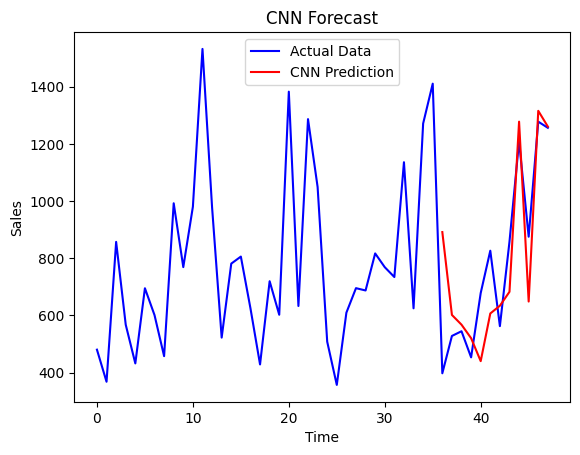

In [13]:
df_plot = np.array(orginalData['Sales'])
plt.plot(df_plot, label='Actual Data', color='blue')
plt.plot(range(len(df_plot)-12, len(df_plot)), average_forecastCNN[-12:], 'r', label='CNN Prediction')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('CNN Forecast')
plt.legend(loc='best')
plt.show()